## Acquiring the data

In [2]:

import pandas as pd
import glob

#Adding relative path name to data variable. Dataset suffix is data when it's available

for i in glob.glob('../data/data*.csv'):
    data = i
    
#Rows skipped to avoid additional cleaning, dates parsed and date used as the index

MM = pd.read_csv(data, skiprows=[1, 483], header= 0, 
                 na_values=0, parse_dates=['Payouts Payout Currency'], 
                 index_col='Payouts Payout Currency').rename_axis(None)

In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#This function sets the beginning of the time series based on first 3 consecutives weeks without FX MM
def series_begins(x):
    nan_index = x.index[x.isnull()]
    for i in range(0,len(nan_index)):
        upper = i + 2
        difference = nan_index[i] - nan_index[(upper)]
        if difference.days == 14:
            return nan_index[i]


In [ ]:
MM['KRW'].loc[series_ends(MM['KRW']):].index[MM['KRW'].loc[series_ends(MM['KRW']):].isnull()]

In [ ]:
#This function sets the end of the time series based on last 2 consecutives weeks with FX MM
def series_ends(x):
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            return notnan_index[i]

In [ ]:
def series_ends_begins(x):
    ends_begins = []
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            ends_begins.append(notnan_index[i])
            nan_index = x.loc[ends_begins[0]:].index[x.loc[ends_begins[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    ends_begins.append(nan_index[i])
                    return ends_begins
                
                
type(series_ends_begins(MM['GBP']))

In [4]:
"""
This function lists the end, based on last 2 consecutives weeks with FX MM
and the start, based on on first 3 consecutives weeks without FX MM, of the timeseries.
"""


def series_end_start(x):
    end_start = [0,0]
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            end_start[0] = notnan_index[i]
            nan_index = x.loc[end_start[0]:].index[x.loc[end_start[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    end_start[1] = nan_index[i]
                    return end_start

In [ ]:
series_end_start(MM['PEN'])

In [ ]:
series_ends_begins(MM['KRW'])

In [ ]:
series = [0,0]
series[1] = 1
series

In [ ]:
#Beginning dates are passed on a dictionary per feature in the data set

dict_series_begings = {i:series_begins(MM[i]) for i in MM.columns}

In [5]:
#Series end and start dates are passed on to dictionary

dict_series_end_start = {i:series_end_start(MM[i]) for i in MM.columns}

In [ ]:
MM.loc[dict_series_end_start['USD'][0]:dict_series_end_start['USD'][1],'USD'].iloc[:-1]

In [6]:
#The function creates a data frame bounded by the end and start of the series

def get_df(x):
    try:
        series = MM.loc[dict_series_end_start[x][0]:dict_series_end_start[x][1],x].iloc[:-1].fillna(0)
        df_output = series.reset_index().rename({'index':'ds', x:'y'}, axis=1)
        return df_output
    except:
        return print(f"There isn't enough historic data to predict {x} volumes or {x} is not a valid market.")

In [ ]:
get_df('GUA')

In [9]:
from matplotlib import pyplot as plt
from fbprophet import Prophet

In [21]:
def create_forecast(market, period, frequency):
    X = get_df(market)
    m = Prophet(seasonality_mode='multiplicative')
    
    m.fit(X)
    future = m.make_future_dataframe(periods=period, freq=frequency)
    future.tail()
    forecast = m.predict(future)
    m.plot(forecast)

In [36]:
?Prophet.make_future_dataframe

Signature:
Prophet.make_future_dataframe(
    self,
    periods,
    freq='D',
    include_history=True,
)
Docstring:
Simulate the trend using the extrapolated generative model.

Parameters
----------
periods: Int number of periods to forecast forward.
freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
include_history: Boolean to include the historical dates in the data
    frame for predictions.

Returns
-------
pd.Dataframe that extends forward from the end of self.history for the
requested number of periods.
File:      ~/miniconda3/envs/final-project/lib/python3.7/site-packages/fbprophet/forecaster.py
Type:      function


In [25]:
MM['USD']

2020-03-16    4.192343e+06
2020-03-09    1.234588e+07
2020-03-02    1.310827e+07
2020-02-24    1.597301e+07
2020-02-17    1.453787e+07
Name: USD, dtype: float64

In [31]:
#Cross Validation

from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(model = m, initial = pd.to_timedelta(208, unit="W"), 
                              horizon = pd.to_timedelta(52, unit="W"))

cv_results.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-19 00:00:00 and 2019-03-18 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-26,2.584076e+06,2.271036e+06,2.874018e+06,3.009348e+06,2018-03-19
1,2018-04-02,2.446484e+06,2.111023e+06,2.766685e+06,2.929199e+06,2018-03-19
2,2018-04-09,2.379040e+06,2.073323e+06,2.687342e+06,3.335554e+06,2018-03-19
3,2018-04-16,2.655676e+06,2.372900e+06,2.954983e+06,3.500180e+06,2018-03-19
4,2018-04-23,3.304384e+06,3.000500e+06,3.597006e+06,4.523989e+06,2018-03-19


In [32]:
from fbprophet.diagnostics import performance_metrics


df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,35 days,1.253783e+12,1.119724e+06,9.074947e+05,0.181654,0.164794,0.266667
1,42 days,1.007017e+12,1.003502e+06,7.746328e+05,0.152010,0.139796,0.400000
2,49 days,1.518355e+12,1.232215e+06,9.575019e+05,0.169206,0.169649,0.400000
3,56 days,2.634667e+12,1.623166e+06,1.160442e+06,0.179745,0.169649,0.400000
4,63 days,3.890592e+12,1.972458e+06,1.428793e+06,0.202580,0.231911,0.266667


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds
325 2020-03-22
326 2020-03-29
327 2020-04-05
328 2020-04-12
329 2020-04-19


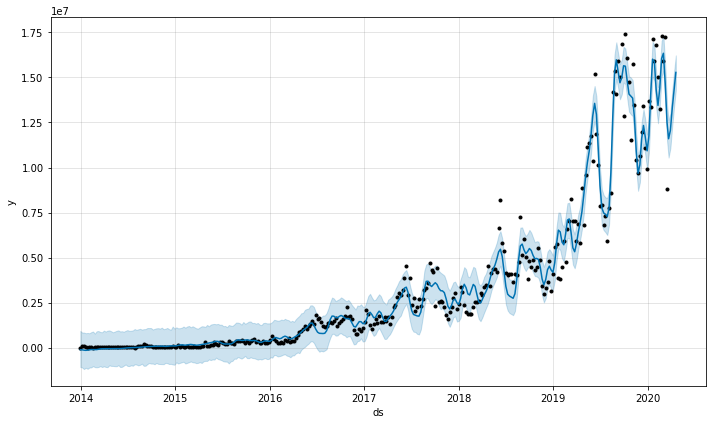

In [26]:
create_forecast('CAD', 5, 'W')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


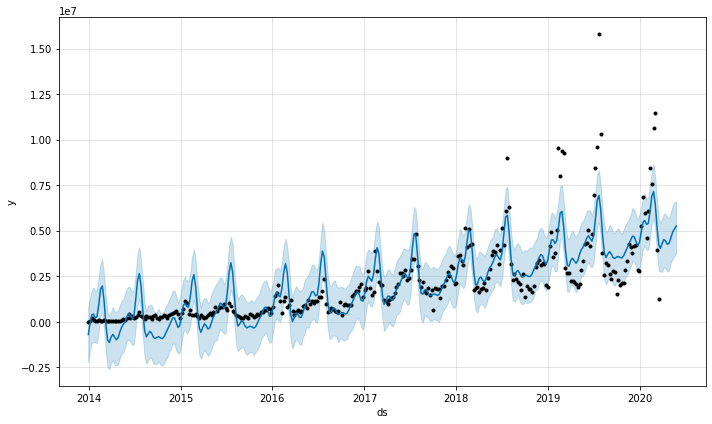

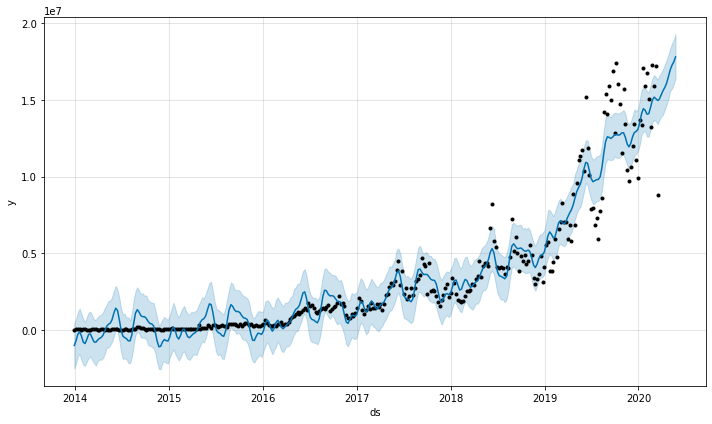

In [10]:
for i in ['AUD', 'CAD']:
    create_forecast(i, 10, 'W')

#create_forecast('CAD', 10, 'W')

In [41]:
baseline = get_df('CAD')
m = Prophet(seasonality_mode='multiplicative')

m.fit(baseline)
futures = m.make_future_dataframe(periods=5, freq=pd.date_range(freq='W', normalize=True))
futures.tail()
#fcst = m.predict(futures)
#fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: Of the four parameters: start, end, periods, and freq, exactly three must be specified

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


In [ ]:
MM.apply(lambda x: series_begins(x['AUD']), axis=1)

In [ ]:
MM.apply(lambda x: series_begins(x['AUD']), axis=1)

## Cleaning Data

In [ ]:
MM.isnull().sum().sort_values()

In [ ]:
MM['USD'].sum()